# 带掩码的自编码器（MAE）

## 模型简介

MAE(Masked Autoencoders)是用于CV的自监督学习方法，在论文[Masked Autoencoders Are Scalable Vision Learners](https://link.zhihu.com/?target=https%3A//arxiv.org/pdf/2111.06377.pdf)中被提出。其优点是扩展性强的（scalable），方法简单。在MAE方法中会随机mask输入图片的部分patches，然后重构这些缺失的像素。MAE基于两个核心设计：（1）不对称的（asymmetric）编码解码结构，编码器仅仅对可见的patches进行编码，不对mask tokens进行任何处理，解码器将编码器的输出（latent representation）和mask tokens作为输入，重构image；（2）使用较高的mask比例（如75%）。MAE展现了很强的迁移性能，在ImageNet-1K上取得了best accuracy（87.8%），且因为方法简单，可扩展性极强（scalable）

> 本篇基于GPU/Ascend环境运行。

### 方法

掩码自编码器 (MAE) 是一种简单的自编码方法，可以在给定部分观察的情况下重建原始信号。与所有自动编码器一样，方法有一个编码器，将观察到的信号映射到潜在表示，以及一个解码器，从潜在表示重建原始信号。与经典的自动编码器不同，采用非对称设计，允许编码器仅对部分观察到的信号进行操作（没有掩码标记）和一个轻量级解码器，从潜在表示和掩码标记重建完整信号。下图说明了这个想法，接下来将逐个介绍。

<p align="center">
  <img src="https://user-images.githubusercontent.com/11435359/146857310-f258c86c-fde6-48e8-9cee-badd2b21bd2c.png" width="480">
</p>

#### （1）掩码

遵循 ViT，将图像划分为规则的非重叠patch。然后对patch的子集进行采样并屏蔽（即删除）剩余的patch。采样策略很简单：按照均匀分布对随机patch进行采样，无需替换。简单地将其称为“随机抽样”。具有高掩蔽率（即移除patch的比率）的随机采样在很大程度上消除了冗余，从而创建了一项无法通过从可见相邻patch外推来轻松解决的任务。均匀分布可防止潜在的中心偏差（即在图像中心附近有更多被屏蔽的patch）。最后，高度稀疏的输入为设计高效编码器创造了机会，接下来介绍。

#### （2）MAE 编码器

编码器是 ViT ，但仅应用于可见的、未屏蔽的patch。就像在标准 ViT 中一样，编码器通过添加位置嵌入的线性投影嵌入patch，然后通过一系列 Transformer 块处理结果集。然而，编码器只对整个集合的一小部分（例如 25%）进行操作。被屏蔽的patch被移除；不使用掩码token。能够仅使用一小部分计算和内存来训练非常大的编码器。全套由轻量级解码器处理，如下所述。

#### （3）MAE 解码器

MAE 解码器的输入是完整的token set，包括编码的可见patch和掩码token。参见上图。每个掩码标记是一个共享的、学习的向量，表示存在要预测的缺失补丁。为这个完整集合中的所有标记添加了位置嵌入；如果没有这个，掩码token将没有关于它们在图像中的位置的信息。解码器有另一系列的 Transformer 模块。MAE 解码器仅在预训练期间用于执行图像重建任务（仅使用编码器生成用于识别的图像表示）。因此，可以以独立于编码器设计的方式灵活地设计解码器架构。试验了非常小的解码器，比编码器更窄更浅。例如，与编码器相比，默认解码器每个令牌的计算量小于10%。通过这种非对称设计，全套token仅由轻量级解码器处理，这显着减少了预训练时间。

#### （4）重建目标

MAE 通过预测每个掩码patch的像素值来重建输入。解码器输出中的每个元素都是一个表示patch的像素值向量。解码器的最后一层是线性投影，其输出通道的数量等于patch中像素值的数量。解码器的输出被重新整形以形成重建的图像。损失函数计算像素空间中重建图像和原始图像之间的均方误差(MSE)。

### 模型特点

（1）MAE的成功，一些突破常规的设计，比如很高的masking ratio，这是很难想象会work的，但MAE却证明了这是成功的关键

（2）效果十分惊艳！遮住95%的像素后，仍能还原出物体的轮廓。

（3）与当前SOTA自监督预训练方法相比，对于 ViT-B 的表现结果都很接近。对于 ViT-L不同方法的结果就存在很大差距，这表明更大模型的挑战是减少过度拟合。再看最后一列，仅使用ImageNet-1K数据时，ViT-Huge模型的最高精确度为87.8%，这明显超过了所有在ImageNet-21K 预训练的ViT变种模型。与 BEiT方法相比，MAE更准确、更简单、更高效。
<p align="center">
  <img src="https://img-blog.csdnimg.cn/9458d9a67a384052ba209c748e00dc29.png" width="480">
</p>

本教程将使用ImageNet-1K的照片来训练一个带掩码的自编码器（MAE），进行图像重建。

为了节省运行时间，建议用户使用GPU/Ascend来运行本实验。

## 准备环节

In [1]:
import os
import time
import json
import re
import math
import random
import PIL
from PIL import Image, ImageOps, ImageEnhance
from io import BytesIO
from mindspore import Tensor
from mindspore import dtype as mstype
from mindspore import nn
from mindspore import ops as P
from mindspore.common.initializer import initializer, XavierUniform
from mindspore.common.parameter import Parameter
from mindspore.nn.transformer import TransformerEncoder, TransformerDecoder
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig
from mindspore.train.callback._callback import Callback
from mindspore.train.serialization import load_checkpoint
from mindspore.train.serialization import load_param_into_net
from mindspore.train.model import Model
import mindspore as ms
import mindspore.dataset as de
import mindspore.dataset.vision.c_transforms as C
import mindspore.dataset.vision.py_transforms as P2
from mindspore.dataset.vision.utils import Inter
import mindspore.dataset.transforms.c_transforms as C2
import mindspore.nn as nn1
import mindspore.numpy as np
from mindspore.nn.loss.loss import LossBase
import numpy as np1
from mindspore.ops import operations as P1
import mindspore.common.dtype as mstype1
from mindspore.common.tensor import Tensor as Tensor1
from mindspore.nn.learning_rate_schedule import LearningRateSchedule, PolynomialDecayLR, WarmUpLR, CosineDecayLR
import matplotlib.pyplot as plt

### 导入模块

### 配置环境

本教程我们在Ascend环境下，使用图模式运行实验。

In [2]:
from mindspore import context
context.set_context(device_target='Ascend', mode=context.GRAPH_MODE)

### 准备数据

在本教程中，我们将使用[ImageNet2012 数据集](https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_train.tar)，ImageNet是一个计算机视觉系统识别项目，是目前世界上图像识别最大的数据库。是美国斯坦福的计算机科学家，模拟人类的识别系统建立的。能够从图片中识别物体。ImageNet是一个非常有前景的研究项目，未来用在机器人身上，就可以直接辨认物品和人了。

- 数据集大小：125G，共1000个类、125万张彩色图像
    - 训练集：120G，共120万张图像
    - 测试集：5G，共5万张图像
- 数据格式：RGB

我们使用到的数据为`ILSVRC2012_img_train.tar`，为了完整流畅地运行程序，需要在当前路径下创建一个`data`目录，并在`data`目录下创建一个名为`imagetnet2012`的目录，并将压缩文件解压缩到该目录中，之后将解压后的训练集目录改为train。

数据集下载完成后使用以下代码创建imagenet训练集的文件的索引json文件，用于后续训练使用。

In [ ]:
dataset_dir = "./data/imagenet2012/train"
dic = {}
for item in os.listdir(dataset_dir):
    for file in os.listdir(os.path.join(dataset_dir, item)):
        if str(file).find('.JPEG') > -1:
            dic[str(file)] = str(item)
json.dump(dic, open('./data/imagenet2012/tot_ids.json', 'w'), indent=4)

最终得到目录结构如下：

```text
./data/imagetnet2012
    -> infer
    -> train
        -> n01440764
            -> n01440764_18.JPEG
            -> n01440764_36.JPEG
            -> n01440764_37.JPEG
        -> n01443537
           ...
    -> val
    -> tot_index.json
```

## 数据处理

- 定义`DataLoader`类用于加载数据集。

In [12]:
class DataLoader:

    def __init__(self, imgs_path, data_dir=None):
        with open(imgs_path, 'r') as f:
            data = json.load(f)
        if data_dir is not None:
            data = [os.path.join(data_dir, data[item] + "/" + item) for item in data]
        self.data = data

    def __getitem__(self, index):
        img = Image.open(self.data[index]).convert('RGB')
        return (img,)

    def __len__(self):
        return len(self.data)

- 定义`create_imagenet_dataset`函数对数据进行处理和增强操作。

In [ ]:
# 创建Image_net的数据集
def create_imagenet_dataset():
    # imagenet的均值和方差
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    # 创建数据集
    dataset = de.GeneratorDataset(
        source=DataLoader("./data/imagenet2012/tot_ids.json", data_dir="./data/imagenet2012/train"),
        column_names="image", num_shards=1,
        shard_id=0, shuffle=True)
    # transform的具体操作
    trans = [
        C.RandomResizedCrop(224, scale=(0.2, 1.0), ratio=(0.75, 1.333), interpolation=Inter.BICUBIC),
        C.RandomHorizontalFlip(prob=0.5),
        C.Normalize(mean=mean, std=std),
        C.HWC2CHW(),
    ]
    # 进行transform
    ds = dataset.map(input_columns="image", num_parallel_workers=8, operations=trans, python_multiprocessing=True)
    # 对数据集进行混洗
    ds = ds.shuffle(buffer_size=10)
    # 取对应的batch_size大小的数据合并作为一个批处理数据
    ds = ds.batch(64, drop_remainder=True)
    # repeat数据集一次
    ds = ds.repeat(1)
    return ds

# 获取处理后的数据集
dataset = create_imagenet_dataset()
# 获取数据集大小
data_size = dataset.get_dataset_size()

per_step_size = data_size
print("Will be Training epochs:{}， sink_size:{}".format(800, per_step_size))
print("Create training dataset finish, data size:{}".format(data_size))

- 通过`create_dict_iterator`函数将数据转换成字典迭代器，然后使用`matplotlib`模块可视化部分训练数据。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

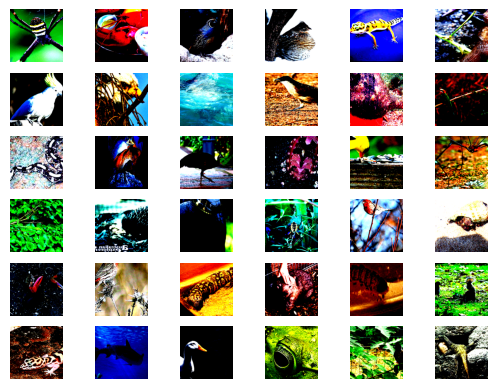

In [18]:
data_iter = next(dataset.create_dict_iterator(output_numpy=True, num_epochs=800))
images = data_iter['image']
count = 1

# 可视化36张图片
for i in images[:36]:
    plt.subplot(6, 6, count)
    plt.imshow(i.transpose(1, 2, 0))
    plt.axis("off")
    plt.xticks([])
    count += 1

plt.show()

## 创建网络

当处理完数据后，就可以来进行网络的搭建了。下面将逐一讲解MAE模块，以及MAE中的编码器和MAE整体训练架构等。

### MAE模块

教程遵循MAE论文中的内容，masking_ratio默认为0.75，使用ops中的函数遮掩相应的patch。

In [3]:
class MAEModule(nn.Cell):
    """MAE的基本模块"""
    def __init__(self, batch_size, image_size, patch_size, masking_ratio=0.75, channels=3):
        super(MAEModule, self).__init__()
        assert 0 < masking_ratio < 1, '掩盖率masking ratio必须是要是在0到1之间的'
        self.num_patches = (image_size // patch_size) ** 2 # 一张图片中patch的数量
        self.num_masked = int(self.num_patches * masking_ratio) # 被遮盖的patch的数量
        self.batch_range = np.arange(batch_size)[:, None] # 升维，例如array([0, 1, 2])变array([[0], [1], [2]])
        self.patch_dim = channels * patch_size ** 2 # 一个patch中所有像素点的通道数之和
        # 计算需要遮罩的patch，并获得随机索引，用于划分为masked和unmasked
        self.rand_indices = P.Sort()(P.UniformReal()((batch_size, self.num_patches)))
        self.masked_indices = self.rand_indices[1][:, :self.num_masked] # masked的索引
        self.unmasked_indices = self.rand_indices[1][:, self.num_masked:] # unmasked的索引
        self.mask_info = None
        self.encoder = None
        self.decoder = None

    def generate_mask(self):
        self.mask_info = {
            "batch_range": self.batch_range,
            "mask_indices": self.masked_indices,
            "unmasked_indices": self.unmasked_indices
        }
        return self.mask_info

    def encoder_engine(self):
        return self.encoder

    def decoder_engine(self):
        return self.decoder

### 编码器

编码器是 ViT ，但仅应用于可见的、未屏蔽的patch。就像在标准 ViT 中一样，编码器通过添加位置嵌入的线性投影嵌入patch，然后通过一系列 Transformer 块处理结果集。

对于二维的图像，首先需要将其转换为patch网格，然后再进行后续操作，以下两个类就是实现了切分图像和patch嵌入的功能。

In [4]:
class Patchify(nn.Cell):
    """将图片转换成patches"""
    # 初始化
    def __init__(self, patch_size):
        super(Patchify, self).__init__()
        self.patch_size = patch_size
        self.reshape = P.Reshape()
        self.transpose = P.Transpose()

    # 构建对应功能
    def construct(self, img):
        p = self.patch_size # 获取patch_size大小
        bs, channels, h, w = img.shape # 获取数据的batchsize、channel、height、width
        x = self.reshape(img, (bs, channels, h // p, p, w // p, p))
        x = self.transpose(x, (0, 2, 4, 1, 3, 5))
        patches = self.reshape(x, (bs, (h//p)*(w//p), channels*p*p)) # 将图片数据转换成patch格式
        return patches

class PatchEmbed(nn.Cell):
    """创建patch的位置编码 positional embedding"""
    def __init__(self, img_size=224, patch_size=16, in_features=3, out_features=768):
        super(PatchEmbed, self).__init__()
        self.hybrid = None
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])   # 计算patch的形状（长宽）
        self.projection = nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=patch_size, # 二维卷积核的高度和宽度
                                    stride=patch_size, has_bias=True)
        self.reshape = P.Reshape()
        self.transpose = P.Transpose()  # 矩阵转置
        self.norm = nn.LayerNorm((out_features,), epsilon=1e-6).to_float(ms.float32)
    # 构建对应方法
    def construct(self, x):
        x = self.projection(x)
        x = self.reshape(x, (x.shape[0], x.shape[1], x.shape[2] * x.shape[3]))
        x = self.transpose(x, (0, 2, 1))
        x = self.norm(x)
        return x

由于在编码器中一个核心的步骤就是对patch进行位置编码，因此以下的函数用于将二维图像中的patch使用sin-cos位置编码方式将其编码为一维的。

In [5]:
# 获取二维sin-cos位置编码
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    # 获取每个小patch的长度和宽度
    grid_h = np1.arange(grid_size, dtype=np1.float32)
    grid_w = np1.arange(grid_size, dtype=np1.float32)
    grid = np1.meshgrid(grid_w, grid_h)  # 得到坐标系
    grid = np1.stack(grid, axis=0)  # 生成两个网格
    grid = grid.reshape([2, 1, grid_size, grid_size])  # 修改网格形状
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np1.concatenate([np1.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed  # 返回最终的二维位置编码

# 从网格中获取二维sin-cos位置编码
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    # 将两个一维的位置编码拼接到一起，得到整体的位置编码。
    emb = np1.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb

# 从网格中获取一维sin-cos位置编码(两个一维的位置编码拼接到一起即可得到整体的位置编码)
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np1.arange(embed_dim // 2, dtype=np1.float)
    omega /= embed_dim / 2.
    # 归一化
    omega = 1. / 10000**omega  # (D/2,)
    pos = pos.reshape(-1)  # (M,)
    out = np1.einsum('m,d->md', pos, omega)  # (M, D/2), outer product
    emb_sin = np1.sin(out)  # (M, D/2)
    emb_cos = np1.cos(out)  # (M, D/2)
    emb = np1.concatenate([emb_sin, emb_cos], axis=1)  # (M, D) 对所有值取得sin和cos之后在conn起来。但是是1维的。
    return emb  # 返回的是将所有值的sin、cos值连接起来的结果

MAEEncoder类定义了编码器的结构，它继承自MAEModule。

In [6]:
class MAEEncoder(MAEModule):
    def __init__(self, batch_size, patch_size, image_size, encoder_layers=12, encoder_num_heads=12, encoder_dim=768, mlp_ratio=4, masking_ratio=0.75,
                 drop_path=0.1, channels=3, initialization=XavierUniform()):
        super(MAEEncoder, self).__init__(batch_size, image_size, patch_size, masking_ratio, channels)
        self.seq_length = self.num_patches - self.num_masked + 1 # 编码器中输入序列的长度，输入的序列为未被mask的patch
        self.encoder = TransformerEncoder(batch_size=batch_size, num_layers=encoder_layers, num_heads=encoder_num_heads, hidden_size=encoder_dim,
                                          ffn_hidden_size=encoder_dim * mlp_ratio, seq_length=self.seq_length, hidden_dropout_rate=drop_path)
        cls_token = Parameter(initializer(initialization, (1, 1, encoder_dim)), name='cls', requires_grad=True)
        self.cls_token = P.Tile()(cls_token, (batch_size, 1, 1))
        self.encoder_pos_embedding = Parameter(
            initializer(initialization, (1, self.num_patches + 1, encoder_dim)),
            name='pos_embedding', requires_grad=False
        )
        self.add = P.Add()
        self.cat = P.Concat(axis=1) # 两列拼接
        self.stride_slice = P.StridedSlice()    # 输入Tensor根据步长和索引进行切片提取
        self.norm = nn.LayerNorm((encoder_dim,), epsilon=1e-6).to_float(mstype.float32)
        # 对patch进行embedding操作
        self.patch_embed = PatchEmbed(img_size=image_size, patch_size=patch_size, in_features=channels, out_features=encoder_dim) # 输出的特征通道数
        self.encoder_input_mask = Tensor(np.ones((batch_size, self.seq_length, self.seq_length)), mstype.float32)
        self._init_weights()    # 初始化权重

    def _init_weights(self):
        encoder_pos_emd = Tensor(
            get_2d_sincos_pos_embed(self.encoder_pos_embedding.shape[-1], int(self.num_patches ** .5), cls_token=True),
            mstype.float32
        )
        self.encoder_pos_embedding.set_data(P.ExpandDims()(encoder_pos_emd, 0))

    def construct(self, img):
        # 将patch变为token并加上位置编码
        tokens = self.patch_embed(img)
        encoder_pos_embedding = self.stride_slice(self.encoder_pos_embedding, (0, 1, 0),
                                                  (1, self.encoder_pos_embedding.shape[1], self.encoder_pos_embedding.shape[2]),
                                                  (1, 1, 1))
        tokens = self.add(tokens, encoder_pos_embedding)
        tokens = tokens[self.batch_range, self.unmasked_indices]    # 得到未被mask的token
        # 得到cls_token并添加上位置编码
        cls_pos_embedding = self.stride_slice(self.encoder_pos_embedding, (0, 0, 0), (1, 1, self.encoder_pos_embedding.shape[2]), (1, 1, 1))
        cls_tokens = self.add(self.cls_token, cls_pos_embedding)
        tokens = self.cat((cls_tokens, tokens)) # 将cls_token和tokens进行拼接
        # 得到最终需要进行encode的tokens
        encoded_tokens = self.encoder(tokens, self.encoder_input_mask)[0]
        encoded_tokens = self.norm(encoded_tokens)
        return encoded_tokens

### MAE整体架构

接下来创建MAE预训练的整体架构。由于MAE是基于ViT的，而ViT可以根据其模型规模分为三种，分别为ViT-Base、ViT-Large和ViT-Huge，以下表格展示了三种ViT网络结构的不同。本案例是基于ViT-Base模型的，如需改用其他类型，只用修改相应参数即可。
<p align="center">
  <img src="https://pic2.zhimg.com/80/v2-54f717f71079becca62a0247660a171d_1440w.jpg" width="480">
</p>

In [25]:
class PreTrainMAEVit(MAEModule):

    def __init__(self, batch_size, patch_size, image_size, encoder_layers=12, decoder_layers=8, encoder_num_heads=12, decoder_num_heads=16,
                 encoder_dim=768, decoder_dim=512, mlp_ratio=4, masking_ratio=0.75, drop_path=0.1, channels=3, norm_pixel_loss=False,
                 initialization=XavierUniform()):
        super(PreTrainMAEVit, self).__init__(batch_size, image_size, patch_size, masking_ratio, channels)   # 集成父类
        self.encoder = MAEEncoder(batch_size, patch_size, image_size, encoder_layers=encoder_layers, encoder_dim=encoder_dim,
                                  encoder_num_heads=encoder_num_heads, mlp_ratio=mlp_ratio, drop_path=drop_path, initialization=initialization)
        # 解码器的参数
        self.seq_length = self.encoder.seq_length
        tgt_seq_length = self.num_patches + 1
        self.mask_token = Parameter(P.StandardNormal()((decoder_dim,)))
        self.mask_tokens = P.Tile()(self.mask_token, (batch_size, self.num_masked, 1))  # 按照给定的次数复制输入Tensor
        # 从编码器到解码器的全连接层
        self.enc_to_dec = nn.Dense(encoder_dim, decoder_dim, has_bias=True) if encoder_dim != decoder_dim else P.Identity()
        self.decoder = TransformerDecoder(batch_size=batch_size, num_layers=decoder_layers, num_heads=decoder_num_heads, hidden_size=decoder_dim,
                                          ffn_hidden_size=decoder_dim * mlp_ratio, src_seq_length=self.seq_length, tgt_seq_length=tgt_seq_length)
        # 得到解码器的位置编码
        decoder_pos_emd = Tensor(get_2d_sincos_pos_embed(decoder_dim, int(self.num_patches ** .5), cls_token=True), mstype.float32)
        self.decoder_pos_embedding = nn.Embedding(tgt_seq_length, decoder_dim, embedding_table=decoder_pos_emd) # 解码器的位置编码
        self.decoder_pos_embedding.requires_grad = False
        self.attention_mask = Tensor(np.ones((batch_size, tgt_seq_length, tgt_seq_length)), mstype.float32)
        self.to_pixels = nn.Dense(decoder_dim, self.patch_dim, has_bias=True)   # 解码器和patch间的全连接层
        self.decoder_norm = nn.LayerNorm((decoder_dim,), epsilon=1e-6).to_float(mstype.float32)
        self.patchify = Patchify(patch_size=patch_size)
        self.add = P.Add()
        self.divide = P.Div()
        self.cast = P.Cast()
        self.cat = P.Concat(axis=1)
        self.pow = P.Pow()
        self.mean = P.ReduceMean(keep_dims=True)
        self.norm_pixel_loss = norm_pixel_loss
        self.mse_loss = nn.MSELoss()    # loss指定为MSELoss

    def calc_loss(self, pred, target):
        pred = self.cast(pred, mstype.float32)  # 改变数据类型
        target = self.cast(target, mstype.float32)  # 改变数据类型
        if self.norm_pixel_loss:
            mean = self.mean(target, -1)
            var = target.var(axis=-1, keepdims=True)
            target = self.divide(target - mean, self.pow(var + 1e-6, 0.5))
        recon_loss = self.mse_loss(pred, target)    # 计算loss
        return recon_loss

    def construct(self, img, label=None):
        encoder_tokens = self.encoder(img) # 得到要输入编码器的patch
        patches = self.patchify(img)
        decoder_tokens = self.enc_to_dec(encoder_tokens) # 从编码器到解码器
        img_tokens = decoder_tokens[:, 1:, :] # 给编码器的token加上位置编码
        cls_tokens = decoder_tokens[:, :1, :]
        decoder_tokens_ = self.add(img_tokens, self.decoder_pos_embedding(self.unmasked_indices))
        decoder_tokens = self.cat((cls_tokens, decoder_tokens_))
        # 根据上面得到的mask的索引为被遮掩的token加上位置编码
        mask_tokens = self.add(self.mask_tokens, self.decoder_pos_embedding(self.masked_indices))
        decoder_tokens = self.cat((decoder_tokens, mask_tokens)) # 将编码器的token和被遮掩的token进行拼接
        decoded_tokens = self.decoder(decoder_tokens, self.attention_mask)[0]
        decoded_tokens = self.decoder_norm(decoded_tokens) # 将编码器的token进行标准化
        decoded_tokens = decoded_tokens[:, 1:, :] # 将所有的token投影到像素上
        pred_pixel_values = self.to_pixels(decoded_tokens)
        masked_patches = patches[self.batch_range, self.masked_indices] # 根据索引将patch进行排序
        unmasked_patches = patches[self.batch_range, self.unmasked_indices]
        sort_patches = self.cat((unmasked_patches, masked_patches))
        loss = self.calc_loss(pred_pixel_values, sort_patches) # 计算重建的损失
        return loss

实例化MAE

In [ ]:
# 实例化模型
net = PreTrainMAEVit(batch_size=64, patch_size=16, image_size=224, encoder_layers=12, decoder_layers=8, encoder_num_heads=12, decoder_num_heads=16,
                     encoder_dim=768, decoder_dim=512, mlp_ratio=4, masking_ratio=0.75)

### 学习率与优化器

接下来来创建学习率的调整策略，LearningRate类作为辅助类

In [16]:
class LearningRate(LearningRateSchedule):
    """ 学习率 """
    def __init__(self, start_learning_rate, end_learning_rate, total_epochs, warmup_epochs, steps_per_epoch, power=2.0, use_cosine=True):
        super(LearningRate, self).__init__()
        self.warmup_flag = False # 是否进行热身
        total_steps = total_epochs * steps_per_epoch
        warmup_steps = int(warmup_epochs * steps_per_epoch)
        decay_steps = total_steps - warmup_steps # 衰减的steps
        # 热身部分
        if warmup_steps > 0:
            self.warmup_flag = True
            self.warmup_lr = WarmUpLR(start_learning_rate, warmup_steps) # 基于WarmUp衰减函数计算学习率
        self.decay_lr = PolynomialDecayLR(start_learning_rate, end_learning_rate, decay_steps, power) # 基于多项式衰减函数计算学习率
        self.cosine_decay_lr = CosineDecayLR(end_learning_rate, start_learning_rate, decay_steps) # 基于余弦衰减函数计算学习率
        self.warmup_steps = Tensor1(np1.array([warmup_steps]).astype(np1.float32))
        self.greater = P1.Greater()
        self.one = Tensor1(np1.array([1.0]).astype(np1.float32))  # 独热编码后比较大小
        self.cast = P1.Cast() # 数据类型转换
        self.use_cosine = use_cosine # 是否使用余弦衰减

    # 构造对应的方法
    def construct(self, global_step):
        if not self.use_cosine: # 判断是否使用余弦衰减函数计算学习率
            decay_lr = self.decay_lr(global_step)
        else:
            decay_lr = self.cosine_decay_lr(global_step)
        if self.warmup_flag: # 是否使用warmup优化
            is_warmup = self.cast(self.greater(self.warmup_steps, global_step), mstype1.float32)
            warmup_lr = self.warmup_lr(global_step)
            lr = (self.one - is_warmup) * decay_lr + is_warmup * warmup_lr
        else:
            lr = decay_lr
        return lr

In [ ]:
# 定义开始时的学习率
start_learning_rate = (0.00015 * 64) / 256
# 根据epoch训练次数来调整学习率
lr_schedule = LearningRate(start_learning_rate, 0.000000000001, 800, 40, data_size)

### 损失函数与优化器

- 在进行训练时需要时刻监控损失函数的变化，以下为用到的代码。

In [29]:
tot_loss = []
class LossMonitor(Callback):
    def __init__(self, data_size, per_print_times=1):
        super(LossMonitor, self).__init__()
        if not isinstance(per_print_times, int) or per_print_times < 0:
            raise ValueError("The argument 'per_print_times' must be int and >= 0, but got {}".format(per_print_times))
        self._per_print_times = per_print_times
        self._last_print_time = 0
        self.epoch_time = time.time()
        self.data_size = data_size

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs[0].asnumpy()
        cur_step_in_epoch = (cb_params.cur_step_num - 1) % cb_params.batch_num + 1
        if isinstance(loss, float) and (np1.isnan(loss) or np1.isinf(loss)):
            raise ValueError("epoch: {} step: {}. Invalid loss, terminating training.".format(cb_params.cur_epoch_num, cur_step_in_epoch))
        if self._per_print_times != 0 and (cb_params.cur_step_num - self._last_print_time) >= self._per_print_times:
            self._last_print_time = cb_params.cur_step_num
            # print("epoch: %s step: %s, loss is %s" % (cb_params.cur_epoch_num, cur_step_in_epoch, loss))
            epoch_seconds = (time.time() - self.epoch_time)
            per_step_seconds = epoch_seconds / self.data_size
            print_str = "epoch[{}]".format(cb_params.cur_epoch_num)
            print_str += ', epoch time: {:.2f}s'.format(epoch_seconds)
            print_str += ', per step time: {:.4f}s'.format(per_step_seconds)
            print_str += ', loss={:.6f}'.format(loss)
            print(print_str)
            self.epoch_time = time.time()
            tot_loss.append(loss)

- 使用Adam权重衰减的方式定义优化器。

In [ ]:
# 定义优化器，使用权重衰减Adam算法
optimizer = nn.AdamWeightDecay(net.trainable_params(), learning_rate=lr_schedule, weight_decay=0.05, beta1=0.9, beta2=0.95)

### 模型训练

- 首先，构建训练网络

In [ ]:
# 动态更新损失缩放系数(loss scale)的神经元
scale_manager = nn1.wrap.loss_scale.DynamicLossScaleUpdateCell(loss_scale_value=2 ** 24, scale_factor=2, scale_window=2000)
# 如果不使用权重滑动平均，就使用混合精度功能的训练网络。
train_model = nn1.TrainOneStepWithLossScaleCell(net, optimizer, scale_sense=scale_manager)
# 定义模型并开始训练
model = Model(train_model)

- 然后进行训练网络，每经过800次迭代，并且使用LossMonitor监控损失变化


In [ ]:
model.train(800, dataset, callbacks=LossMonitor(dataset.get_dataset_size()), sink_size=per_step_size)

epoch[1], epoch time: 1100.01s, per step time: 0.4282s, loss=1.137318
epoch[2], epoch time: 896.04s, per step time: 0.3488s, loss=0.922776
epoch[3], epoch time: 896.07s, per step time: 0.3488s, loss=0.726554
epoch[4], epoch time: 896.04s, per step time: 0.3488s, loss=0.862340
epoch[5], epoch time: 896.04s, per step time: 0.3488s, loss=0.733227
epoch[6], epoch time: 896.03s, per step time: 0.3488s, loss=0.637901
epoch[7], epoch time: 896.12s, per step time: 0.3488s, loss=0.480187
epoch[8], epoch time: 895.95s, per step time: 0.3488s, loss=0.577174
epoch[9], epoch time: 896.04s, per step time: 0.3488s, loss=0.478641
epoch[10], epoch time: 895.99s, per step time: 0.3488s, loss=0.445327
epoch[11], epoch time: 896.11s, per step time: 0.3488s, loss=0.370698


- 运行下面代码，描绘损失与训练迭代的关系图：

In [ ]:
plt.figure(figsize=(20, 5))
plt.title("Reconstruction Loss During Training")
plt.plot([i+1 for i in range(len(tot_loss))], tot_loss, color='blue')
plt.xticks([i+1 for i in range(len(tot_loss))])
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

![Reconstruction Loss During Training](https://img-blog.csdnimg.cn/c951ca8611c7422089ece6aaf13cb0aa.png)

- 以下是理想情况下图像修复前后的效果。

![图像修复效果](https://cuijiahua.com/wp-content/uploads/2022/01/ai-26-10.png)

### 分类任务训练与推理过程

在MAE的论文中，推理过程主要是使用编码器来进行图片分类等下游任务，因此该部分主要是针对图片分类任务进行训练与推理。

- 定义数据增强的相关操作

In [7]:
class AugmentOp:
    def __init__(self, name, prob=0.5, magnitude=10, hparams=None):
        self.aug_fn = NAME_TO_OP[name]
        self.level_fn = LEVEL_TO_ARG[name]
        self.prob = prob
        self.magnitude = magnitude
        self.hparams = hparams.copy()
        self.kwargs = dict(
            fillcolor=hparams['img_mean'],
            resample=hparams['interpolation'],
        )
        self.magnitude_std = self.hparams.get('magnitude_std', 0)

    def __call__(self, img):
        if self.prob < 1.0 and random.random() > self.prob:
            return img
        magnitude = self.magnitude
        if self.magnitude_std:
            if self.magnitude_std == float('inf'):
                magnitude = random.uniform(0, magnitude)
            elif self.magnitude_std > 0:
                magnitude = random.gauss(magnitude, self.magnitude_std)
        magnitude = min(10., max(0, magnitude))  # clip to valid range
        level_args = self.level_fn(magnitude, self.hparams) if self.level_fn is not None else tuple()
        return self.aug_fn(img, *level_args, **self.kwargs)

# 生成对应格式和size的数据
def _get_pixels(per_pixel, rand_color, patch_size, dtype=np1.float32):
    if per_pixel:
        func = np1.random.normal(size=patch_size).astype(dtype)
    elif rand_color:
        func = np1.random.normal(size=(patch_size[0], 1, 1)).astype(dtype)
    else:
        func = np1.zeros((patch_size[0], 1, 1), dtype=dtype)
    return func

class RandomErasing:
    # 初始化，设置对应的参数数值
    def __init__(self, probability=0.5, min_area=0.02, max_area=1 / 3, min_aspect=0.3, max_aspect=None, mode='const', min_count=1,
                 max_count=None, num_splits=0):
        self.probability = probability
        self.min_area = min_area
        self.max_area = max_area
        max_aspect = max_aspect or 1 / min_aspect
        self.log_aspect_ratio = (math.log(min_aspect), math.log(max_aspect))
        self.min_count = min_count
        self.max_count = max_count or min_count
        self.num_splits = num_splits
        mode = mode.lower()
        self.rand_color = False
        self.per_pixel = False
        if mode == 'rand':
            self.rand_color = True  # per block random normal
        elif mode == 'pixel':
            self.per_pixel = True  # per pixel random normal
        else:
            assert not mode or mode == 'const'
    # 擦除操作
    def _erase(self, img, chan, img_h, img_w, dtype):
        if random.random() > self.probability: # 设置对应的随机数，与擦除可能性阈值进行比较
            pass
        else:
            area = img_h * img_w # 计算面积
            # 设置要磨除的个数，在最小和最大之间
            count = self.min_count if self.min_count == self.max_count else random.randint(self.min_count, self.max_count)
            for _ in range(count):
                for _ in range(10):
                    target_area = random.uniform(self.min_area, self.max_area) * area / count # 计算最终呗mask的面积
                    aspect_ratio = math.exp(random.uniform(*self.log_aspect_ratio)) # 计算mask的占比
                    h = int(round(math.sqrt(target_area * aspect_ratio)))
                    w = int(round(math.sqrt(target_area / aspect_ratio)))
                    if w < img_w and h < img_h: # 判断是否符合要求
                        top = random.randint(0, img_h - h)
                        left = random.randint(0, img_w - w)
                        img[:, top:top + h, left:left + w] = _get_pixels(self.per_pixel, self.rand_color, (chan, h, w), dtype=dtype)
                        break
        return img

    def __call__(self, x):
        if len(x.shape) == 3:
            output = self._erase(x, *x.shape, x.dtype)
        else: # 如果格式不符合，调整为正确格式之后在执行方法
            output = np1.zeros_like(x)
            batch_size, chan, img_h, img_w = x.shape
            # skip first slice of batch if num_splits is set (for clean portion of samples)
            batch_start = batch_size // self.num_splits if self.num_splits > 1 else 0
            for i in range(batch_start, batch_size):
                output[i] = self._erase(x[i], chan, img_h, img_w, x.dtype)
        return output

class RandAugment:
    def __init__(self, ops, num_layers=2, choice_weights=None):
        self.ops = ops
        self.num_layers = num_layers
        self.choice_weights = choice_weights

    def __call__(self, img):
        ops = np1.random.choice(self.ops, self.num_layers, replace=self.choice_weights is None, p=self.choice_weights)
        for op in ops:
            img = op(img)
        return img

def rand_augment_ops(magnitude=10, hparams=None, transforms=None):
    transforms = transforms or _RAND_TRANSFORMS
    return [AugmentOp(name, prob=0.5, magnitude=magnitude, hparams=hparams) for name in transforms]
def one_hot(x, num_classes, on_value=1., off_value=0.):
    x = x.reshape(-1)   # 将x的维度打成一维
    x = np1.eye(num_classes)[x]  # np1.eye用于生成一个num_classes*num_classes的二维数组，且对角线上的元素为1，其余为0
    x = np1.clip(x, a_min=off_value, a_max=on_value, dtype=np1.float32)   # 将x中小于off_value的替换为off_value，将大于on_value的替换为on_value
    return x
def mixup_target(target, num_classes, lam=1., smoothing=0.0):
    off_value = smoothing / num_classes
    on_value = 1. - smoothing + off_value
    y1 = one_hot(target, num_classes, on_value=on_value, off_value=off_value)
    y2 = one_hot(np1.flip(target, axis=0), num_classes, on_value=on_value, off_value=off_value)
    return y1 * lam + y2 * (1. - lam)
def rand_bbox(img_shape, lam, margin=0., count=None):
    ratio = np1.sqrt(1 - lam)
    img_h, img_w = img_shape[-2:]
    cut_h, cut_w = int(img_h * ratio), int(img_w * ratio)
    margin_y, margin_x = int(margin * cut_h), int(margin * cut_w)
    cy = np1.random.randint(0 + margin_y, img_h - margin_y, size=count)
    cx = np1.random.randint(0 + margin_x, img_w - margin_x, size=count)
    yl = np1.clip(cy - cut_h // 2, 0, img_h)
    yh = np1.clip(cy + cut_h // 2, 0, img_h)
    xl = np1.clip(cx - cut_w // 2, 0, img_w)
    xh = np1.clip(cx + cut_w // 2, 0, img_w)
    return yl, yh, xl, xh
def rand_bbox_minmax(img_shape, minmax, count=None):
    assert len(minmax) == 2
    img_h, img_w = img_shape[-2:]
    cut_h = np1.random.randint(int(img_h * minmax[0]), int(img_h * minmax[1]), size=count)
    cut_w = np1.random.randint(int(img_w * minmax[0]), int(img_w * minmax[1]), size=count)
    yl = np1.random.randint(0, img_h - cut_h, size=count)
    xl = np1.random.randint(0, img_w - cut_w, size=count)
    yu = yl + cut_h
    xu = xl + cut_w
    return yl, yu, xl, xu
def cutmix_bbox_and_lam(img_shape, lam, ratio_minmax=None, correct_lam=True, count=None):
    if ratio_minmax is not None:
        yl, yu, xl, xu = rand_bbox_minmax(img_shape, ratio_minmax, count=count)
    else:
        yl, yu, xl, xu = rand_bbox(img_shape, lam, count=count)
    if correct_lam or ratio_minmax is not None:
        bbox_area = (yu - yl) * (xu - xl)
        lam = 1. - bbox_area / float(img_shape[-2] * img_shape[-1])
    return (yl, yu, xl, xu), lam

class Mixup:
    def __init__(self, mixup_alpha=1., cutmix_alpha=0., cutmix_minmax=None, prob=1.0, switch_prob=0.5, mode='batch', correct_lam=True,
                 label_smoothing=0.1, num_classes=1000):
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.cutmix_minmax = cutmix_minmax
        if self.cutmix_minmax is not None:
            assert len(self.cutmix_minmax) == 2
            self.cutmix_alpha = 1.0 # 当minmax处于活动状态时，强制cutmix的alpha==1.0，以保持逻辑简单和安全
        self.mix_prob = prob
        self.switch_prob = switch_prob
        self.label_smoothing = label_smoothing
        self.num_classes = num_classes
        self.mode = mode
        self.correct_lam = correct_lam  # 根据cutmix的剪裁面积校正lambda
        self.mixup_enabled = True  # 设置为false使得mixup不起作用

    def _params_per_batch(self):
        lam = 1.
        use_cutmix = False
        if self.mixup_enabled and np1.random.rand() < self.mix_prob:
            if self.mixup_alpha > 0. and self.cutmix_alpha > 0.:
                use_cutmix = np1.random.rand() < self.switch_prob
                lam_mix = np1.random.beta(self.cutmix_alpha, self.cutmix_alpha) if use_cutmix else np1.random.beta(self.mixup_alpha, self.mixup_alpha)
            elif self.mixup_alpha > 0.:
                lam_mix = np1.random.beta(self.mixup_alpha, self.mixup_alpha)
            elif self.cutmix_alpha > 0.:
                use_cutmix = True
                lam_mix = np1.random.beta(self.cutmix_alpha, self.cutmix_alpha)
            else:
                assert False, "One of mixup_alpha > 0., cutmix_alpha > 0., cutmix_minmax not None should be true."
            lam = float(lam_mix)
        return lam, use_cutmix

    def _mix_batch(self, x):
        lam, use_cutmix = self._params_per_batch()
        if lam == 1.:
            return 1.
        if use_cutmix:
            (yl, yh, xl, xh), lam = cutmix_bbox_and_lam(x.shape, lam, ratio_minmax=self.cutmix_minmax, correct_lam=self.correct_lam)
            x[:, :, yl:yh, xl:xh] = np1.flip(x, axis=0)[:, :, yl:yh, xl:xh]
        else:
            x_flipped = np1.flip(x, axis=0) * (1. - lam)
            x *= lam
            x += x_flipped
        return lam
    # 将类的对象当作函数直接调用
    def __call__(self, x, target):
        assert len(x) % 2 == 0, 'Batch size should be even when using this'
        lam = self._mix_batch(x)
        target = mixup_target(target, self.num_classes, lam, self.label_smoothing)
        return x.astype(np1.float32), target.astype(np1.float32)

_PIL_VER = tuple([int(x) for x in PIL.__version__.split('.')[:2]])
def _interpolation(kwargs):
    interpolation = kwargs.pop('resample', Image.Resampling.BILINEAR)
    interpolation = random.choice(interpolation) if isinstance(interpolation, (list, tuple)) else interpolation
    return interpolation
def _randomly_negate(v):
    return -v if random.random() > 0.5 else v
def _check_args_tf(kwargs):
    if 'fillcolor' in kwargs and _PIL_VER < (5, 0):
        kwargs.pop('fillcolor')
    kwargs['resample'] = _interpolation(kwargs)
def auto_contrast(img, **__):
    return ImageOps.autocontrast(img)
def equalize(img, **__):
    return ImageOps.equalize(img)
def invert(img, **__):
    return ImageOps.invert(img)
def rotate(img, degrees, **kwargs):
    _check_args_tf(kwargs)
    if _PIL_VER >= (5, 2):
        func = img.rotate(degrees, **kwargs)
    elif _PIL_VER >= (5, 0):
        w, h = img.size
        post_trans = (0, 0)
        rotn_center = (w / 2.0, h / 2.0)
        angle = -math.radians(degrees)
        matrix = [round(math.cos(angle), 15), round(math.sin(angle), 15), 0.0, round(-math.sin(angle), 15), round(math.cos(angle), 15), 0.0]
        def transform(x, y, matrix):
            (a, b, c, d, e, f) = matrix
            return a * x + b * y + c, d * x + e * y + f
        matrix[2], matrix[5] = transform(-rotn_center[0] - post_trans[0], -rotn_center[1] - post_trans[1], matrix)
        matrix[2] += rotn_center[0]
        matrix[5] += rotn_center[1]
        func = img.transform(img.size, Image.Transform.AFFINE, matrix, **kwargs)
    else:
        func = img.rotate(degrees, resample=kwargs['resample'])
    return func
def posterize(img, bits_to_keep, **__):
    if bits_to_keep >= 8:
        func = img
    else:
        func = ImageOps.posterize(img, bits_to_keep)
    return func
def solarize(img, thresh, **__):
    return ImageOps.solarize(img, thresh)
def solarize_add(img, add, thresh=128, **__):
    lut = []
    for i in range(256):
        if i < thresh:
            lut.append(min(255, i + add))
        else:
            lut.append(i)
    if img.mode in ("L", "RGB"):
        if img.mode == "RGB" and len(lut) == 256:
            lut = lut + lut + lut
        func = img.point(lut)
    else:
        func = img
    return func
def color(img, factor, **__):
    return ImageEnhance.Color(img).enhance(factor)
def contrast(img, factor, **__):
    return ImageEnhance.Contrast(img).enhance(factor)
def brightness(img, factor, **__):
    return ImageEnhance.Brightness(img).enhance(factor)
def sharpness(img, factor, **__):
    return ImageEnhance.Sharpness(img).enhance(factor)
def shear_x(img, factor, **kwargs):
    _check_args_tf(kwargs)
    return img.transform(img.size, Image.Transform.AFFINE, (1, factor, 0, 0, 1, 0), **kwargs)
def shear_y(img, factor, **kwargs):
    _check_args_tf(kwargs)
    return img.transform(img.size, Image.Transform.AFFINE, (1, 0, 0, factor, 1, 0), **kwargs)
def translate_x_abs(img, pixels, **kwargs):
    _check_args_tf(kwargs)
    return img.transform(img.size, Image.Transform.AFFINE, (1, 0, pixels, 0, 1, 0), **kwargs)
def translate_y_abs(img, pixels, **kwargs):
    _check_args_tf(kwargs)
    return img.transform(img.size, Image.Transform.AFFINE, (1, 0, 0, 0, 1, pixels), **kwargs)
def translate_x_rel(img, pct, **kwargs):
    pixels = pct * img.size[0]
    _check_args_tf(kwargs)
    return img.transform(img.size, Image.Transform.AFFINE, (1, 0, pixels, 0, 1, 0), **kwargs)
def translate_y_rel(img, pct, **kwargs):
    pixels = pct * img.size[1]
    _check_args_tf(kwargs)
    return img.transform(img.size, Image.Transform.AFFINE, (1, 0, 0, 0, 1, pixels), **kwargs)
def _rotate_level_to_arg(level, _hparams):
    level = (level / 10.) * 30.
    level = _randomly_negate(level)
    return (level,)
def _posterize_level_to_arg(level, _hparams):
    return (int((level / 10.) * 4),)
def _posterize_increasing_level_to_arg(level, hparams):
    return (4 - _posterize_level_to_arg(level, hparams)[0],)
def _posterize_original_level_to_arg(level, _hparams):
    return (int((level / 10.) * 4) + 4,)
def _solarize_level_to_arg(level, _hparams):
    return (int((level / 10.) * 256),)
def _solarize_increasing_level_to_arg(level, _hparams):
    return (256 - _solarize_level_to_arg(level, _hparams)[0],)
def _solarize_add_level_to_arg(level, _hparams):
    return (int((level / 10.) * 110),)
def _enhance_level_to_arg(level, _hparams):
    return ((level / 10.) * 1.8 + 0.1,)
def _enhance_increasing_level_to_arg(level, _hparams):
    level = (level / 10.) * .9
    level = 1.0 + _randomly_negate(level)
    return (level,)
def _enhance_level_to_arg(level, _hparams):
    return ((level / 10.) * 1.8 + 0.1,)
def _shear_level_to_arg(level, _hparams):
    level = (level / 10.) * 0.3
    level = _randomly_negate(level)
    return (level,)
def _translate_abs_level_to_arg(level, hparams):
    translate_const = hparams['translate_const']
    level = (level / 10.) * float(translate_const)
    level = _randomly_negate(level)
    return (level,)
def _translate_rel_level_to_arg(level, hparams):
    translate_pct = hparams.get('translate_pct', 0.45)
    level = (level / 10.) * translate_pct
    level = _randomly_negate(level)
    return (level,)

LEVEL_TO_ARG = {
    'AutoContrast': None, 'Equalize': None, 'Invert': None, 'Rotate': _rotate_level_to_arg, 'Posterize': _posterize_level_to_arg,
    'PosterizeIncreasing': _posterize_increasing_level_to_arg, 'PosterizeOriginal': _posterize_original_level_to_arg, 'Solarize': _solarize_level_to_arg,
    'SolarizeIncreasing': _solarize_increasing_level_to_arg, 'SolarizeAdd': _solarize_add_level_to_arg, 'Color': _enhance_level_to_arg,
    'ColorIncreasing': _enhance_increasing_level_to_arg, 'Contrast': _enhance_level_to_arg, 'ContrastIncreasing': _enhance_increasing_level_to_arg,
    'Brightness': _enhance_level_to_arg, 'BrightnessIncreasing': _enhance_increasing_level_to_arg, 'Sharpness': _enhance_level_to_arg,
    'SharpnessIncreasing': _enhance_increasing_level_to_arg, 'ShearX': _shear_level_to_arg, 'ShearY': _shear_level_to_arg,
    'TranslateX': _translate_abs_level_to_arg, 'TranslateY': _translate_abs_level_to_arg, 'TranslateXRel': _translate_rel_level_to_arg,
    'TranslateYRel': _translate_rel_level_to_arg,
}
NAME_TO_OP = {
    'AutoContrast': auto_contrast, 'Equalize': equalize, 'Invert': invert, 'Rotate': rotate, 'Posterize': posterize, 'PosterizeIncreasing': posterize,
    'PosterizeOriginal': posterize, 'Solarize': solarize, 'SolarizeIncreasing': solarize, 'SolarizeAdd': solarize_add, 'Color': color,
    'ColorIncreasing': color, 'Contrast': contrast, 'ContrastIncreasing': contrast, 'Brightness': brightness, 'BrightnessIncreasing': brightness,
    'Sharpness': sharpness, 'SharpnessIncreasing': sharpness, 'ShearX': shear_x, 'ShearY': shear_y, 'TranslateX': translate_x_abs,
    'TranslateY': translate_y_abs, 'TranslateXRel': translate_x_rel, 'TranslateYRel': translate_y_rel,
}
_RAND_INCREASING_TRANSFORMS = [
    'AutoContrast', 'Equalize', 'Invert', 'Rotate', 'PosterizeIncreasing', 'SolarizeIncreasing', 'SolarizeAdd', 'ColorIncreasing', 'ContrastIncreasing',
    'BrightnessIncreasing', 'SharpnessIncreasing', 'ShearX', 'ShearY', 'TranslateXRel', 'TranslateYRel',
]
_RAND_TRANSFORMS = [
    'AutoContrast', 'Equalize', 'Invert', 'Rotate', 'Posterize', 'Solarize', 'SolarizeAdd', 'Color', 'Contrast', 'Brightness', 'Sharpness',
    'ShearX', 'ShearY', 'TranslateXRel', 'TranslateYRel',
]

def rand_augment_transform(config_str, hparams):
    magnitude = 10.  # default to _MAX_LEVEL for magnitude (currently 10)
    num_layers = 2  # default to 2 ops per image
    transforms = _RAND_TRANSFORMS
    config = config_str.split('-')
    assert config[0] == 'rand'
    config = config[1:]
    for c in config:
        cs = re.split(r'(\d.*)', c)
        if len(cs) < 2:
            continue
        key, val = cs[:2]
        if key == 'mstd':
            hparams.setdefault('magnitude_std', float(val))
        elif key == 'inc':
            if bool(val):
                transforms = _RAND_INCREASING_TRANSFORMS
        elif key == 'm':
            magnitude = int(val)
        elif key == 'n':
            num_layers = int(val)
        elif key != 'w':
            assert False, 'Unknown RandAugment config section'
    ra_ops = rand_augment_ops(magnitude=magnitude, hparams=hparams, transforms=transforms)
    choice_weights = None
    return RandAugment(ra_ops, num_layers, choice_weights=choice_weights)

- 获取用于下游任务的训练集和验证集

In [8]:
def create_dataset(dataset_path, do_train=True, image_size=224, interpolation="BICUBIC", crop_min=0.08, repeat_num=1, batch_size=32,
                   auto_augment="rand-m9-mstd0.5-inc1", mixup=0.0, mixup_prob=1.0, switch_prob=0.5, cutmix=1.0, hflip=0.5, re_prop=0.25,
                   re_mode='pixel', re_count=1, label_smoothing=0.1, num_classes=1000):
    interpolation = getattr(Inter, interpolation)

    if do_train:
        ds = de.ImageFolderDataset(dataset_path, num_parallel_workers=8, shuffle=True, num_shards=1, shard_id=0)
    else:
        # 确定每步处理的batch数量
        batch_per_step = batch_size
        if batch_per_step < 50000:
            if 50000 % batch_per_step == 0:
                num_padded = 0
            else:
                num_padded = batch_per_step - (50000 % batch_per_step)
        else:
            num_padded = batch_per_step - 50000
        if num_padded != 0:
            # padded_with_decode
            write_io = BytesIO()
            Image.new('RGB', (image_size, image_size), (255, 255, 255)).save(write_io, 'JPEG')
            padded_sample = {'image': np1.array(bytearray(write_io.getvalue()), dtype='uint8'), 'label': np1.array(-1, np1.int32)}
            sample = [padded_sample for x in range(num_padded)]  # 定义样本数据
            ds_pad = de.PaddedDataset(sample)  # 根据定义的样本数据构建数据集
            ds_imagefolder = de.ImageFolderDataset(dataset_path, num_parallel_workers=8)  # 从树状结构的文件目录中读取图片构建源数据集
            ds = ds_pad + ds_imagefolder
            distribute_sampler = de.DistributedSampler(num_shards=1, shard_id=0, shuffle=False, num_samples=None)  # 将数据集进行分片用于分布式训练
            ds.use_sampler(distribute_sampler)
        else:
            ds = de.ImageFolderDataset(dataset_path, num_parallel_workers=8, shuffle=False, num_shards=1, shard_id=0)

    if do_train:
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        aa_params = dict(translate_const=int(image_size * 0.45), img_mean=tuple([min(255, round(255 * x)) for x in mean]))
        assert auto_augment.startswith('rand')
        aa_params['interpolation'] = interpolation
        trans = [
            # 在随机位置裁剪输入图像，以RGB模式对裁剪后的图像进行解码，并调整解码图像的尺寸大小。
            C.RandomCropDecodeResize(image_size, scale=(crop_min, 1.0), ratio=(3 / 4, 4 / 3), interpolation=interpolation),
            C.RandomHorizontalFlip(prob=hflip),  # 对输入图像按给定的概率进行水平随机翻转。
            P2.ToPIL(),  # 将已解码的numpy.ndarray图像转换为PIL图像。
            rand_augment_transform(auto_augment, aa_params),  # Rand-Augment数据增强
            P2.ToTensor(),
            P2.Normalize(mean=mean, std=std),  # 归一化
            RandomErasing(probability=re_prop, mode=re_mode, max_count=re_count)  # Random-Erasing数据增强
        ]
    else:
        mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
        std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
        trans = [
            C.Decode(),  # Decode()用于对输入图像进行解码。
            C.Resize(int(256 / 224 * image_size), interpolation=interpolation),  # 对输入图像应用中心区域裁剪
            C.CenterCrop(image_size),  # 对输入图像应用中心区域裁剪
            C.Normalize(mean=mean, std=std),  # 根据均值和标准差对输入图像进行归一化。
            C.HWC2CHW()  # 将输入图像的shape从 <H, W, C> 转换为 <C, H, W>。
        ]
    type_cast_op = C2.TypeCast(mstype.int32)
    ds = ds.map(input_columns="image", num_parallel_workers=8, operations=trans, python_multiprocessing=True)
    ds = ds.map(input_columns="label", num_parallel_workers=8, operations=type_cast_op)
    ds = ds.batch(batch_size, drop_remainder=True)
    if (mixup > 0. or cutmix > 0.) and do_train:
        mixup_fn = Mixup(
            mixup_alpha=mixup, cutmix_alpha=cutmix,
            cutmix_minmax=None, prob=mixup_prob,
            switch_prob=switch_prob,
            label_smoothing=label_smoothing,
            num_classes=num_classes)
        ds = ds.map(operations=mixup_fn, input_columns=["image", "label"], num_parallel_workers=8)
    ds = ds.repeat(repeat_num)
    return ds

def get_dataset(dataset_path, is_train=True):
    if is_train:
        data = create_dataset(dataset_path=dataset_path, image_size=224, interpolation="BICUBIC", auto_augment="rand-m9-mstd0.5-inc1",
                              mixup=1.0, cutmix=1.0, mixup_prob=1.0, switch_prob=0.5, re_prop=0.5, re_mode='pixel', re_count=1, label_smoothing=0.1,
                              crop_min=0.2, batch_size=128)
    else:
        data = create_dataset(dataset_path=dataset_path, do_train=False, image_size=224, interpolation="BICUBIC", batch_size=128)
    return data

In [9]:
# 获取训练集
train_dataset = get_dataset(dataset_path="./data/imagenet2012/train")
data_size = train_dataset.get_dataset_size()
per_step_size = data_size

# 获取验证集
eval_dataset = get_dataset(dataset_path="./data/imagenet2012/val", is_train=False)
new_epochs = 100

- 由于在将MAE编码器用于下游任务的时候，模型的结构与预训练是并不相同，因此下面重新定义网络结构`FineTuneVit`

In [10]:
class Vit(MAEModule):
    def __init__(self, batch_size, patch_size, image_size, encoder_layers=12, encoder_num_heads=12, encoder_dim=768, mlp_ratio=4, channels=3,
                 dropout=0., drop_path=0.1, global_pool=True, initialization=XavierUniform()):
        super(Vit, self).__init__(batch_size, image_size, patch_size)
        cls_token = Parameter(initializer(initialization, (1, 1, encoder_dim)), name='cls', requires_grad=True)
        self.cls_token = P.Tile()(cls_token, (batch_size, 1, 1))
        seq_length = self.num_patches + 1  # 序列长度加了一个cls_token
        self.encoder_pos_embedding = Parameter(initializer(initialization, (1, seq_length, encoder_dim)), name='pos_embedding', requires_grad=False)
        # Transformer中的编码器模块，具有多层堆叠的TransformerEncoderLayer，包括多头自注意力层和前馈层。
        self.encoder = TransformerEncoder(batch_size=batch_size, num_layers=encoder_layers, num_heads=encoder_num_heads, hidden_size=encoder_dim,
                                          ffn_hidden_size=encoder_dim*mlp_ratio, seq_length=seq_length, hidden_dropout_rate=drop_path)
        self.add = P.Add()  # 对应元素相加
        self.cast = P.Cast()  # 有两个参数，第一是tensor，第二个是数据类型，要把第一个转成第二个数据类型
        self.cat = P.Concat(axis=1)  # 左右两个矩阵相拼接
        self.norm = nn.LayerNorm((encoder_dim,), epsilon=1e-5).to_float(mstype.float32)
        self.fc_norm = nn.LayerNorm((encoder_dim,), epsilon=1e-5).to_float(mstype.float32)
        self.global_pool = global_pool  # 是否进行全局池化
        self.reduce_mean = P.ReduceMean()  # 默认情况下，输出Tensor各维度上的平均值，以达到对所有维度进行归约的目的
        self.patch_embed = PatchEmbed(img_size=image_size, patch_size=patch_size, in_features=channels, out_features=encoder_dim)

        if dropout: # 正则化，在训练过程中随机将一些神经元输出设置为0
            self.is_dropout = True
            self.dropout = nn.Dropout(keep_prob=(1. - dropout))  # keep_prob是输入神经元保留率，数值范围在0到1之间
        self.encoder_input_mask = Tensor(np.ones((batch_size, seq_length, seq_length)), mstype.float32)
        self._init_weights()

    def _init_weights(self):
        # 初始化权重，使用二维sin-cos位置编码
        encoder_pos_emd = Tensor(get_2d_sincos_pos_embed(self.encoder_pos_embedding.shape[-1], int(self.num_patches ** .5), cls_token=True),
                                 mstype.float32)
        self.encoder_pos_embedding.set_data(P.ExpandDims()(encoder_pos_emd, 0))

    def construct(self, img):
        tokens = self.patch_embed(img)  # 得到patch的tokens。
        tokens = self.cat((self.cls_token, tokens))  # 将patch的tokens和cls_token连接起来
        tokens = self.add(tokens, self.encoder_pos_embedding)  # 进行编码，得到最终将要输入到Encoder中的tokens

        if self.is_dropout:
            temp = self.cast(tokens, mstype.float32)  # 将tokens从tensor转为mstype.float32类型
            temp = self.dropout(temp)  # 随机丢弃神经元
            tokens = self.cast(temp, tokens.dtype)  # 把数据类型再转回来
        tokens = self.encoder(tokens, self.encoder_input_mask)[0]  # 将tokens输入到Encoder

        if self.global_pool:
            token = tokens[:, 1:, :]
            tokens = self.reduce_mean(token, 1)  # 对所有维度进行归约
            out = self.fc_norm(tokens)  # 做LayerNorm操作
        else:
            tokens = self.norm(tokens)
            out = tokens[:, 0]
        return out

class FineTuneVit(nn.Cell):
    def __init__(self, batch_size, patch_size, image_size, num_classes=1000, dropout=0., drop_path=0.1, initialization=XavierUniform(), encoder_dim=768):
        super(FineTuneVit, self).__init__()
        self.encoder = Vit(batch_size, patch_size, image_size, dropout=dropout, drop_path=drop_path)  # 编码器是Vit
        self.head = nn.Dense(encoder_dim, num_classes)  # 全连接层
        self.head.weight.set_data(initializer(initialization, [num_classes, encoder_dim]))
    def init_weights(self, param_dict):
        net_not_load = load_param_into_net(self, param_dict)
        return net_not_load
    def construct(self, img):
        tokens = self.encoder(img)
        return self.head(tokens)

- 定义在进行下游分类任务时所需要的度量表现的相关函数，和用于验证的`ImageNetEvelEngine`

In [11]:
class DistAccuracy(nn.Metric):
    def __init__(self, batch_size):
        super(DistAccuracy, self).__init__()
        self.clear()
        self.batch_size = batch_size
    def clear(self):
        # 初始化预测正确的数量，和总预测正确的数量
        self._correct_num = 0
        self._total_num = 0
    def update(self, *inputs):
        if len(inputs) != 1:
            raise ValueError('Distribute accuracy needs 1 input (y_correct), but got {}'.format(len(inputs)))
        y_correct = self._convert_data(inputs[0])
        self._correct_num += y_correct
        self._total_num += self.batch_size
    def eval(self):
        if self._total_num == 0:
            raise RuntimeError('Accuracy can not be calculated, because the number of samples is 0.')
        return self._correct_num / 50000

# 计算验证集上的分类正确率(不使用缓存)
class ClassifyCorrectCell(nn.Cell):
    def __init__(self, network):
        super(ClassifyCorrectCell, self).__init__(auto_prefix=False)
        self._network = network
        self.argmax = P1.Argmax()
        self.equal = P1.Equal()
        self.cast = P1.Cast()
        self.reduce_sum = P1.ReduceSum()
    def construct(self, data, label):
        outputs = self._network(data)
        y_pred = self.argmax(outputs)
        y_pred = self.cast(y_pred, mstype1.int32)
        y_correct = self.equal(y_pred, label)
        y_correct = self.cast(y_correct, mstype1.float32)
        y_correct = self.reduce_sum(y_correct)
        total_correct = y_correct
        return (total_correct,)

# 不使用缓存的ImageNet数据集的验证引擎
class ImageNetEvelEngine:
    def __init__(self, net, eval_dataset, batch_size):
        super().__init__()
        self.eval_dataset = eval_dataset
        self.dist_eval_network = ClassifyCorrectCell(net)
        self.batch_size = batch_size
        self.outputs = None
        self.model = None
    @property
    def metric(self):
        return {'acc': DistAccuracy(batch_size=self.batch_size)}
    @property
    def eval_network(self):
        return self.dist_eval_network
    def compile(self, sink_size=-1):
        pass
    def set_model(self, model):
        self.model = model
    def eval(self):
        self.outputs = self.model.eval(self.eval_dataset)
    def get_result(self):
        return self.outputs["acc"]

In [12]:
# 实例化模型和用于验证的引擎
net = FineTuneVit(batch_size=128, patch_size=16, image_size=224, dropout=0.1, num_classes=1000)
eval_engine = ImageNetEvelEngine(net, eval_dataset, 128)

[WARNING] ME(1723:281473499765312,MainProcess):2022-11-03-15:15:54.336.149 [mindspore/ops/primitive.py:207] The in_strategy of the operator in your network will not take effect in stand_alone mode. This means the the shard function called in the network is ignored. 
If you want to enable it, please use semi auto or auto parallel mode by context.set_auto_parallel_context(parallel_mode=ParallelMode.SEMI_AUTO_PARALLEL or context.set_auto_parallel_context(parallel_mode=ParallelMode.AUTO_PARALLEL)
[WARNING] ME(1723:281473499765312,MainProcess):2022-11-03-15:15:54.338.776 [mindspore/nn/transformer/transformer.py:2388] For parallel mode, sharding propagation is recommended, you can use it by setting 'set_auto_parallel_context(parallel_mode=ParallelMode.AUTO_PARALLEL, search_mode="sharding_propagation")' and 'set_algo_parameters(elementwise_op_strategy_follow=False, fully_use_devices=False)'
[WARNING] ME(1723:281473499765312,MainProcess):2022-11-03-15:15:54.372.185 [mindspore/common/_decorator

- 加载预训练模型

In [ ]:
import requests

if not os.path.exists("./ckpt/mae-base.ckpt"):
    r = requests.get("https://download.mindspore.cn/vision/mae/mae-base.ckpt")
    with open("./ckpt/mae-base.ckpt", "wb") as code:
        code.write(r.content)
params_dict = load_checkpoint("./ckpt/mae-base.ckpt")
load_param_into_net(net, params_dict)

- 定义损失及监控状态变化的工具类

In [14]:
# 定义推理损失
class SoftTargetCrossEntropy(LossBase):
    def __init__(self, reduction='mean'):
        super(SoftTargetCrossEntropy, self).__init__(reduction)
        self.sum = P.ReduceSum(False)
        self.mul = P.Mul()
        self.cast = P.Cast()
        self.softmax = nn.LogSoftmax(axis=-1)

    #构建对应的方法，返回最后的loss结果
    def construct(self, logit, label):
        logit = self.cast(logit, mstype.float32)
        label = self.cast(label, mstype.float32)
        x = self.softmax(logit)
        x = self.mul(-label, x)
        x = self.sum(x, -1)
        return self.get_loss(x)

# 定义状态损失的监控器，用于监控状态变化
class StateMonitor(Callback):
    def __init__(self, data_size, tot_batch_size=None, eval_interval=None, eval_offset=None, eval_engine=None, logger=None):
        super(StateMonitor, self).__init__()
        # 初始化
        self.data_size = data_size
        self.tot_batch_size = tot_batch_size
        self.epoch_num = 0
        self.loss = 0
        self.eval_interval = eval_interval
        self.eval_offset = eval_offset
        self.eval_engine = eval_engine
        self.best_acc = -1
        self.best_acc_top5 = -1
        self.best_i2t_recall = -1
        self.best_t2i_recall = -1
        self.mean_fps = 0.0
        self.print = print
        self.epoch_time = 0
        if logger is not None:
            self.print = logger
    def step_end(self, run_context):
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs

        if isinstance(loss, (tuple, list)):
            if isinstance(loss[0], Tensor) and isinstance(loss[0].asnumpy(), np1.ndarray):
                loss = loss[0]

        if isinstance(loss, Tensor) and isinstance(loss.asnumpy(), np1.ndarray):
            loss = np1.mean(loss.asnumpy())
        self.loss = loss
    def epoch_begin(self, run_context):
        self.epoch_time = time.time()
    def epoch_end(self, run_context):
        epoch_seconds = (time.time() - self.epoch_time)  # 计算训练时间
        per_step_seconds = epoch_seconds / self.data_size  # 计算每个step需要的时间
        print_str = "epoch[{}]".format(self.epoch_num)
        print_str += ', epoch time: {:.2f}s'.format(epoch_seconds)
        print_str += ', per step time: {:.4f}s'.format(per_step_seconds)
        print_str += ', loss={:.6f}'.format(self.loss)
        if self.tot_batch_size is not None:
            fps = self.tot_batch_size * self.data_size / epoch_seconds
            self.mean_fps = (self.mean_fps * self.epoch_num + fps) / (self.epoch_num + 1)
            print_str += ', fps={:.2f}'.format(fps)
        if (self.epoch_num + 1) % self.eval_interval == self.eval_offset:
            eval_start = time.time()
            self.eval_engine.eval()
            output = self.eval_engine.get_result()
            eval_seconds = time.time() - eval_start
            if output is not None:
                if isinstance(output, list):
                    print_str += ', top1 accuracy={:.6f}'.format(float(output[0]))
                    print_str += ', top5 accuracy={:.6f}'.format(float(output[1]))
                    print_str += ', i2t_recall={:.6f}'.format(float(output[2]))
                    print_str += ', t2i_recall={:.6f}'.format(float(output[3]))
                    print_str += ', eval_cost={:.2f}'.format(eval_seconds)
                    # 更新最佳参数的值
                    if float(output[0]) > self.best_acc:
                        self.best_acc = float(output[0])
                    if float(output[1]) > self.best_acc_top5:
                        self.best_acc_top5 = float(output[1])
                    if float(output[2]) > self.best_i2t_recall:
                        self.best_i2t_recall = float(output[2])
                    if float(output[3]) > self.best_t2i_recall:
                        self.best_t2i_recall = float(output[3])
                else:
                    print_str += ', accuracy={:.6f}'.format(float(output))
                    print_str += ', eval_cost={:.2f}'.format(eval_seconds)

                    if float(output) > self.best_acc:
                        self.best_acc = float(output)
        self.print(print_str)
        self.epoch_num += 1

- 开始微调训练与推理的设置

In [17]:
# 定义推理损失
vit_loss = SoftTargetCrossEntropy()

# 定义开始时的学习率
start_learning_rate = (0.0001 *  128) / 256

# 根据epoch训练次数来调整学习率
lr_schedule = LearningRate(start_learning_rate, 0.000000000001, new_epochs, 10, data_size)

# 定义优化器
optimizer = nn.AdamWeightDecay(net.trainable_params(), learning_rate=lr_schedule, weight_decay=0.05, beta1=0.9, beta2=0.999)

# 构建训练网络
net_with_loss = nn.WithLossCell(net, vit_loss)
net_with_train = net_with_loss = nn.TrainOneStepWithLossScaleCell(net_with_loss, optimizer,
                                                                  scale_sense=nn.wrap.FixedLossScaleUpdateCell(loss_scale_value=1024))
model = Model(net_with_train, metrics=eval_engine.metric, eval_network=eval_engine.eval_network)
callbacks = [StateMonitor(data_size=per_step_size, tot_batch_size=128, eval_interval=1, eval_offset=-1, eval_engine=eval_engine), ModelCheckpoint(prefix="MaeFintuneViT-B", directory="./output/", config=CheckpointConfig(save_checkpoint_steps=per_step_size, keep_checkpoint_max=1, integrated_save=False))]
# 设置验证引擎
eval_engine.set_model(model)
eval_engine.compile(sink_size=per_step_size)

- 开始微调训练

In [ ]:
# 开始进行finetune训练及验证推理
model.train(new_epochs, train_dataset, callbacks=callbacks, sink_size=per_step_size, dataset_sink_mode=True)

- 开始推理验证

In [18]:
eval_engine.eval()
output = eval_engine.get_result()
print('accuracy={:.6f}'.format(float(output)))

accuracy=0.799260


## 流程与总结

<p align="center">
  <img src="https://img-blog.csdnimg.cn/022b26908e6f4889bb324212ec146dbf.png" width="480">
</p>

## 引用

[1] He K ,  Chen X ,  Xie S , et al. Masked Autoencoders Are Scalable Vision Learners[J].  2021.

[2] Vaswani A ,  Shazeer N ,  Parmar N , et al. Attention Is All You Need[C]// arXiv. arXiv, 2017.

[3] Dosovitskiy A ,  Beyer L ,  Kolesnikov A , et al. An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale[J].  2020.